# Load data and fragment + index

In [2]:
import os
import pandas as pd
from rdkit import Chem
import subprocess
import hashlib
import tempfile
from tqdm import tqdm
import base64
class MMPGenerator:
    def __init__(self, df_input, output_csv, mmpa_dir='./mmpa',
                 symmetric=True, max_heavy=14, max_ratio=0.7, verbose=True):
        self.df_original = df_input.copy()
        self.output_csv = output_csv
        self.mmpa_dir = mmpa_dir
        self.symmetric = symmetric
        self.max_heavy = max_heavy
        self.max_ratio = max_ratio
        self.verbose = verbose

    def _get_inchikey(self, smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.inchi.MolToInchiKey(mol)
        return self.encode_string(smiles)

    def encode_string(self, s):
        return base64.urlsafe_b64encode(s.encode()).decode()

    def decode_string(self, b64):
        return base64.urlsafe_b64decode(b64.encode()).decode()

    def run(self):
        if self.verbose: print("[1] Generating InChI Keys...")
        self.df_original['ID'] = [self._get_inchikey(smi) for smi in tqdm(self.df_original['SMILES'], disable=not self.verbose)]
        y_map = self.df_original.set_index('ID')['Y'].to_dict()

        with tempfile.TemporaryDirectory() as tmp:
            smi_path = os.path.join(tmp, 'input.smi')
            frag_path = os.path.join(tmp, 'fragmented.txt')
            mmps_path = os.path.join(tmp, 'mmps.csv')
            smirks_path = os.path.join(tmp, 'smirks.txt')
            cansmirks_path = os.path.join(tmp, 'cansmirks.txt')

            if self.verbose: print("[2] Writing SMILES to temp file...")
            self.df_original[['SMILES', 'ID']].to_csv(smi_path, index=False, sep=' ', header=False)

            if self.verbose: print("[3] Running fragmentation (rfrag.py)...")
            with open(frag_path, 'w') as out:
                subprocess.run(['python', f'{self.mmpa_dir}/rfrag.py'], stdin=open(smi_path), stdout=out)

            if self.verbose: print("[4] Running MMP indexing (indexing.py)...")
            cmd = ['python', f'{self.mmpa_dir}/indexing.py']
            if self.symmetric:
                cmd.append('-s')
            if self.max_heavy:
                cmd.extend(['-m', str(self.max_heavy)])
            if self.max_ratio:
                cmd.extend(['-r', str(self.max_ratio)])

            with open(mmps_path, 'w') as out:
                subprocess.run(cmd, stdin=open(frag_path), stdout=out)

            if self.verbose: print("[5] Reading MMPs and annotating...")
            with open(mmps_path) as f:
                lines = [line.strip() for line in f if line.strip()]

            if not lines:
                raise ValueError("No MMPs generated. Likely cause: no valid fragmentation or too strict parameters.")

            splits = [line.split(',') for line in lines]
            max_len = max(len(s) for s in splits)
            if max_len != 6:
                raise ValueError(f"Expected 6 columns per line, got max {max_len}. Check output formatting.")

            df = pd.DataFrame(splits, columns=['L_SMILES', 'R_SMILES', 'L_ID', 'R_ID', 'SMIRKS', 'CORE'])


            df['L_Y'] = df['L_ID'].map(y_map)
            df['R_Y'] = df['R_ID'].map(y_map)
            df['Delta_Y'] = df['R_Y'] - df['L_Y']

            if self.verbose: print("[6] Canonicalizing SMIRKS (cansmirk.py)...")
            df = df[df['SMIRKS'].apply(lambda x: isinstance(x, str) and '>>' in x)]

            df['__row'] = range(len(df))
            df[['SMIRKS', '__row']].to_csv(smirks_path, index=False, sep=' ', header=False)

            with open(cansmirks_path, 'w') as out:
                subprocess.run(['python', f'{self.mmpa_dir}/cansmirk.py'], stdin=open(smirks_path), stdout=out)


            canon_df = pd.read_csv(cansmirks_path, sep=' ', names=['Canonical_SMIRKS', 'index'])


            df = df.merge(canon_df, left_on='__row', right_on='index').drop(columns=['__row', 'index'])

            df[['L_sub', 'R_sub']] = df['Canonical_SMIRKS'].str.split('>>', expand=True)


            df['L_sub_ID'] = [self.encode_string(k) for k in df['L_sub'].tolist()]
            df['R_sub_ID'] = [self.encode_string(k) for k in df['R_sub'].tolist()]
            df['SMIRKS_ID'] = [self.encode_string(k) for k in df['Canonical_SMIRKS'].tolist()]
            df['CORE_ID'] = [self.encode_string(k) for k in df['CORE'].tolist()]
            df = df.drop_duplicates()


            if self.verbose: print(f"[7] Saving final annotated MMPs to: {self.output_csv}")
            df[['L_SMILES', 'R_SMILES', 'L_ID', 'R_ID', 'SMIRKS', 'CORE', 'L_Y', 'R_Y', 'Delta_Y', 'L_sub', 'R_sub', 'L_sub_ID', 'R_sub_ID', 'SMIRKS_ID', 'CORE_ID']].to_csv(
                self.output_csv, index=False
            )

        if self.verbose: print("[✓] MMP processing complete.")

In [3]:
import pandas as pd

# SANOFI___pIC50_IRAK4_HUMAN_Biochemical.csv
# BindingDB___pIC50_IRAK4_HUMAN_Biochemical.csv

# Load CSV
df = pd.read_parquet('./data/cleaned_dataset_toy___key_results.parquet')

# Filter pKi columns with < 2000 non-NaN values
small_pKi_cols = [
    col for col in df.columns
    if "p" in col and "IRAK4" in col and df[col].notna().sum() < 2000
]

# Output list of columns and counts
small_pKi_data = {col: df[col].notna().sum() for col in small_pKi_cols}
for k, v in small_pKi_data.items():
    print(f"{k}: {v} non-NaN values")

SANOFI___pIC50_IRAK4_HUMAN_Biochemical.csv: 1752 non-NaN values


In [4]:
col = "SANOFI___pIC50_IRAK4_HUMAN_Biochemical.csv"
df = df[["SMILES", col]].dropna()
df.columns = ["SMILES", "Y"]
df

,SMILES,Y
103,CN(c1ccccc1OCC)c1[n]c(Nc2c[n]([n]c2C)C2CCNCC2)...,6.266803
1433,CN1CCC(CC1)[n]1cc(c[n]1)Nc1[n]c2cc([s]c2c[n]1)...,6.310691
1989,Cc1c(c[n][n]1CC1CCNCC1)Nc1[n]cc(Cl)c(Nc2ccccc2...,6.397940
2302,Cc1cc([nH][n]1)-c1cccc([n]1)C(=O)Nc1c[nH][n]c1...,7.373660
2545,OC(CNC(=O)c1cc2[nH]c(cc2cc1)-c1[n][nH]c2cc[s]c...,5.115771
...,...,...
1214457,Oc1ccc(cc1-c1cc[n]c(NCC2COCCC2)[n]1)-c1c[nH][n]c1,7.283997
1214730,Oc1ccc(cc1-c1cc[n]c(NCc2[n][n]c3cccc[n]32)[n]1...,7.243364
1215873,COC(=O)CCCCCNc1[n]c(cc[n]1)-c1cc(ccc1O)-c1c[nH...,7.326979
1216189,CC(C)(C)NC(=O)CNc1[n]c(cc[n]1)-c1cc(ccc1O)-c1c...,6.455312


In [5]:
MMPGenerator(df, output_csv='out.csv', symmetric=True, max_heavy=17, max_ratio=0.4, verbose=True).run()

[1] Generating InChI Keys...


100%|██████████| 1752/1752 [00:00<00:00, 4584.16it/s]


[2] Writing SMILES to temp file...
[3] Running fragmentation (rfrag.py)...
[4] Running MMP indexing (indexing.py)...
[5] Reading MMPs and annotating...
[6] Canonicalizing SMIRKS (cansmirk.py)...
[7] Saving final annotated MMPs to: out.csv
[✓] MMP processing complete.


# Augmentation by R group

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import pearsonr
from tqdm import tqdm
import time
from collections import defaultdict

class MMPAugmentorFixed:
    def __init__(self, df, min_common=4, pearson_thresh=0.3, crmsd_thresh=0.4):
        self.df = df.copy()
        self.min_common = min_common
        self.pearson_thresh = pearson_thresh
        self.crmsd_thresh = crmsd_thresh
        self.series = {}
        self.pair_scores = []
        self.filtered_pairs = []
        self.augmented_data = []

    def _extract_series(self):
        start = time.time()
        self.series = {
            core: group for core, group in self.df.groupby("CORE")
        }
        print(f"Series extraction took {time.time() - start:.2f} seconds.")

    def _compute_pairwise_scores(self):
        start = time.time()
        self.pair_scores = []
        series_items = list(self.series.items())
        total_combinations = len(series_items) * (len(series_items) - 1) // 2
        for (core1, df1), (core2, df2) in tqdm(
            combinations(series_items, 2),
            desc="Computing scaffold pair scores",
            total=total_combinations
        ):
            subs1 = set(df1["L_sub"])
            subs2 = set(df2["L_sub"])
            common = subs1 & subs2
            if len(common) < self.min_common:
                continue

            merged = pd.merge(
                df1, df2,
                left_on=["L_sub", "R_sub"],
                right_on=["L_sub", "R_sub"],
                suffixes=('_1', '_2')
            )
            if len(merged) < self.min_common:
                continue

            y1 = merged['Delta_Y_1'].values
            y2 = merged['Delta_Y_2'].values
            crmsd = np.sqrt(np.mean((y1 - y2) ** 2))
            try:
                corr = pearsonr(y1, y2)[0]
            except:
                corr = np.nan

            self.pair_scores.append((core1, core2, crmsd, corr, len(merged)))
        print(f"Pairwise score computation took {time.time() - start:.2f} seconds.")

    def _filter_pairs(self):
        start = time.time()
        self.filtered_pairs = [
            (s1, s2) for s1, s2, rmsd, corr, n in self.pair_scores
            if rmsd <= self.crmsd_thresh and (not np.isnan(corr)) # and corr >= self.pearson_thresh)
        ]
        print(f"Filtering pairs took {time.time() - start:.2f} seconds.")


    def _augment(self):
        start = time.time()
        augmented_entries = []

        for s1, s2 in tqdm(self.filtered_pairs, desc="Performing SAR augmentation"):
            df1 = self.series[s1]
            df2 = self.series[s2]

            tf1 = df1[["L_sub", "R_sub", "Delta_Y"]].to_dict("records")
            tf2 = df2[["L_sub", "R_sub", "Delta_Y"]].to_dict("records")

            df1_dict = defaultdict(list)
            for _, row in df1.iterrows():
                df1_dict[row["L_sub"]].append(row.to_dict())

            df2_dict = defaultdict(list)
            for _, row in df2.iterrows():
                df2_dict[row["L_sub"]].append(row.to_dict())

            for entry in tf1:
                l_sub = entry["L_sub"]
                for base in df2_dict.get(l_sub, []):
                    r_sub = entry["R_sub"]
                    delta = entry["Delta_Y"]
                    new_y = base["L_Y"] + delta
                    smirks_new = l_sub + ">>" + r_sub
                    augmented_entries.append({
                        "CORE": s1,
                        "L_sub": l_sub,
                        "R_sub": r_sub,
                        "L_Y": base["L_Y"],
                        "R_Y": new_y,
                        "Delta_Y": delta,
                        "Annotation": "Predicted",
                        "L_SMILES": base.get("L_SMILES"),
                        "L_ID": base.get("L_ID"),
                        "L_sub_ID": base.get("L_sub_ID"),
                        "R_sub_ID": base64.urlsafe_b64encode(r_sub.encode()).decode(),
                        "SMIRKS": smirks_new,
                        "SMIRKS_ID": base64.urlsafe_b64encode(smirks_new.encode()).decode(),
                        "CORE_ID": base64.urlsafe_b64encode(s1.encode()).decode()
                    })

            for entry in tf2:
                l_sub = entry["L_sub"]
                for base in df1_dict.get(l_sub, []):
                    r_sub = entry["R_sub"]
                    delta = entry["Delta_Y"]
                    new_y = base["L_Y"] + delta
                    smirks_new = l_sub + ">>" + r_sub
                    augmented_entries.append({
                        "CORE": s2,
                        "L_sub": l_sub,
                        "R_sub": r_sub,
                        "L_Y": base["L_Y"],
                        "R_Y": new_y,
                        "Delta_Y": delta,
                        "Annotation": "Predicted",
                        "L_SMILES": base.get("L_SMILES"),
                        "L_ID": base.get("L_ID"),
                        "L_sub_ID": base.get("L_sub_ID"),
                        "R_sub_ID": base64.urlsafe_b64encode(r_sub.encode()).decode(),
                        "SMIRKS": smirks_new,
                        "SMIRKS_ID": base64.urlsafe_b64encode(smirks_new.encode()).decode(),
                        "CORE_ID": base64.urlsafe_b64encode(s2.encode()).decode()
                    })

        self.augmented_data = pd.DataFrame(augmented_entries)
        print(f"Augmentation step took {time.time() - start:.2f} seconds.")


    def run(self):
        self._extract_series()
        self._compute_pairwise_scores()
        self._filter_pairs()
        self._augment()

        original = self.df.copy()
        original["Annotation"] = "Experimental"
        return pd.concat([original, self.augmented_data], ignore_index=True)
    
    def get_pair_scores_df(self):
        """
        Return a DataFrame of scaffold pair scores (cRMSD, Pearson, common MMP count)
        """
        return pd.DataFrame(
            self.pair_scores,
            columns=["Scaffold_1", "Scaffold_2", "cRMSD", "Pearson", "N_common"]
        )

    def get_augmented_only(self):
        """
        Return only the augmented (predicted) entries.
        """
        return self.augmented_data.copy()

In [7]:
augmentor = MMPAugmentorFixed(pd.read_csv("out.csv") , min_common=4, crmsd_thresh=.6)


In [8]:
final_df3 = augmentor.run()

Series extraction took 0.08 seconds.


Computing scaffold pair scores: 100%|██████████| 37840650/37840650 [02:23<00:00, 262829.11it/s]


Pairwise score computation took 143.98 seconds.
Filtering pairs took 0.00 seconds.


Performing SAR augmentation: 100%|██████████| 683/683 [00:11<00:00, 61.26it/s] 


Augmentation step took 12.72 seconds.
Augmentation step took 14.26 seconds.


In [ ]:
final_df3 = final_df3.drop_duplicates() # maybe ?

# Analyze pair relationship

In [194]:
augmentor.get_pair_scores_df()

,Scaffold_1,Scaffold_2,cRMSD,Pearson,N_common
0,C1CC([*:1])CCN1.C1CC1[*:2].CC(C)S(=O)(=O)c1ccc...,C1CC([*:1])CCN1.CC(C)S(=O)(=O)c1ccccc1N[*:3].C...,0.700624,0.081021,12
1,C1CC([*:1])CCN1.C1CC1[*:2].CC(C)S(=O)(=O)c1ccc...,C1CC([*:1])CCN1.CC(C)S(=O)(=O)c1ccccc1[*:3].C[...,0.700624,0.081021,12
2,C1CC([*:1])CCN1.CC(C)(C)S(=O)(=O)c1ccccc1N[*:2],C1CC([*:1])CCN1.CC(C)S(=O)(=O)c1ccccc1N[*:2],0.281520,0.944379,42
3,C1CC([*:1])CCN1.CC(C)(C)S(=O)(=O)c1ccccc1N[*:2],CN=S(C)(=O)c1ccccc1N[*:2].OCC[*:1],0.701809,0.745264,16
4,C1CC([*:1])CCN1.CC(C)(C)S(=O)(=O)c1ccccc1N[*:3...,C1CC([*:1])CCN1.CC(C)S(=O)(=O)c1ccccc1N[*:3].C...,0.265875,0.923450,12
...,...,...,...,...,...
884,c1cc(-c2sc3cnc(Nc4cnn(C5CCOCC5)c4)nc3c2O[*:1])...,c1nn(C2CCOCC2)cc1Nc1ncc2sc(-c3cn[nH]c3)c(O[*:1...,0.275309,0.888835,12
885,c1cc(-c2sc3cnc(Nc4cnn(C5CCOCC5)c4)nc3c2[*:1])ccn1,c1nn(C2CCOCC2)cc1Nc1ncc2sc(-c3cn[nH]c3)c([*:1]...,0.275309,0.888835,12
886,c1cc(-c2sc3cnc([*:1])nc3c2C2CC2)ccn1,c1n[nH]cc1-c1sc2cnc([*:1])nc2c1C1CC1,0.525152,0.953625,12
887,c1cc([*:2])ccn1.c1nn(C2CCOCC2)cc1N[*:1],c1n[nH]cc1[*:2].c1nn(C2CCOCC2)cc1N[*:1],0.275309,0.888835,12


In [15]:
def analyze_scaffold_pair_scores(df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    summary = {
        "Total Pairs": len(df),
        "Mean cRMSD": df["cRMSD"].mean(),
        "Median cRMSD": df["cRMSD"].median(),
        "Std cRMSD": df["cRMSD"].std(),
        "Mean Pearson": df["Pearson"].mean(),
        "Median Pearson": df["Pearson"].median(),
        "Std Pearson": df["Pearson"].std(),
        "Mean N_common": df["N_common"].mean(),
        "Median N_common": df["N_common"].median()
    }

    high_corr = df["Pearson"] > 0.7
    low_crmsd = df["cRMSD"] < 0.5
    enough_common = df["N_common"] >= 5
    strong_pairs = df[high_corr & low_crmsd & enough_common]

    summary.update({
        "High Pearson (>0.7)": high_corr.sum(),
        "Low cRMSD (<0.5)": low_crmsd.sum(),
        "N_common ≥ 5": enough_common.sum(),
        "Strong Pairs (all 3)": len(strong_pairs)
    })

    print("=== Summary Statistics ===")
    for k, v in summary.items():
        print(f"{k}: {v}")

    # Scatterplot: cRMSD vs Pearson
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="cRMSD", y="Pearson", hue="N_common", palette="viridis", size="N_common", sizes=(20, 200), alpha=0.6)
    plt.title("cRMSD vs Pearson (colored by N_common)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Histograms
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df["Pearson"], bins=40, kde=True, ax=axs[0], color="dodgerblue")
    axs[0].set_title("Pearson Correlation Distribution")
    axs[0].set_xlabel("Pearson")

    sns.histplot(df["cRMSD"], bins=40, kde=True, ax=axs[1], color="tomato")
    axs[1].set_title("cRMSD Distribution")
    axs[1].set_xlabel("cRMSD")

    plt.tight_layout()
    plt.show()

    top_corr = df.sort_values("Pearson", ascending=False).head(5)
    top_low_crmsd = df.sort_values("cRMSD").head(5)
    top_common = df.sort_values("N_common", ascending=False).head(5)

    return {
        "summary": summary,
        "top_corr": top_corr,
        "top_low_crmsd": top_low_crmsd,
        "top_common": top_common,
        "strong_pairs": strong_pairs
    }

=== Summary Statistics ===
Total Pairs: 889
Mean cRMSD: 0.4668776559051673
Median cRMSD: 0.4264457371820637
Std cRMSD: 0.24658248777461358
Mean Pearson: 0.6455236304438499
Median Pearson: 0.8181874018485673
Std Pearson: 0.422669111254842
Mean N_common: 27.74915635545557
Median N_common: 16.0
High Pearson (>0.7): 571
Low cRMSD (<0.5): 567
N_common ≥ 5: 889
Strong Pairs (all 3): 459


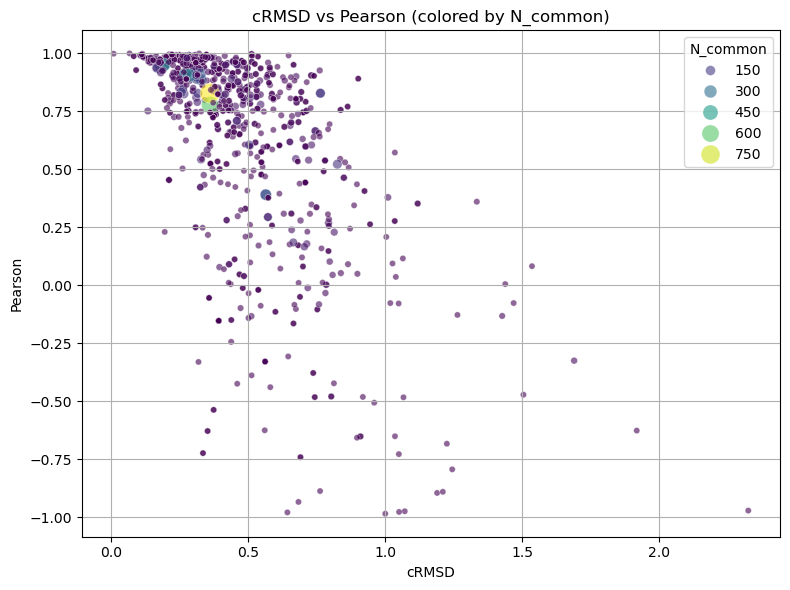

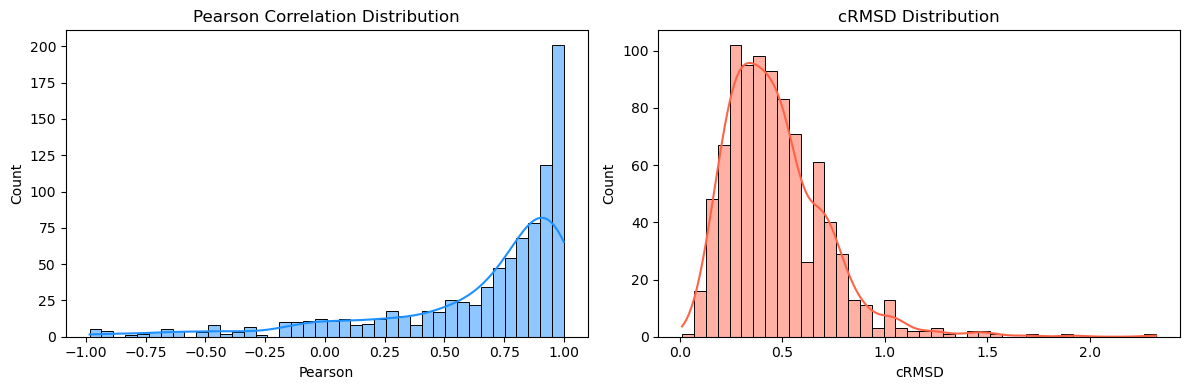

In [16]:


# Run analysis
scaffold_df = augmentor.get_pair_scores_df()
analysis_results = analyze_scaffold_pair_scores(scaffold_df)

# Generate the novel SMILES

In [17]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm

rxn_cache = {}

def fast_apply_transformation(transformation, smiles, rxn_cache):
    if pd.isna(transformation) or pd.isna(smiles):
        return None
    if transformation not in rxn_cache:
        rxn = AllChem.ReactionFromSmarts(transformation)
        rxn_cache[transformation] = rxn
    else:
        rxn = rxn_cache[transformation]
    if rxn is None:
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        products = rxn.RunReactants((mol,))
    except Exception:
        return None
    if products and products[0]:
        return Chem.MolToSmiles(products[0][0])
    return None

def update_predicted_rows(df):
    mask = df["Annotation"] == "Predicted"
    indices = df[mask].index

    for idx in tqdm(indices, desc="Updating predicted rows"):
        row = df.loc[idx]
        l_smiles = row["L_SMILES"]
        smirks = row["SMIRKS"]
        r_smiles = fast_apply_transformation(smirks, l_smiles, rxn_cache)
        if r_smiles:
            mol = Chem.MolFromSmiles(r_smiles)
            r_id = Chem.InchiToInchiKey(Chem.MolToInchi(mol)) if mol else None
        else:
            r_id = None
        df.at[idx, "R_SMILES"] = r_smiles
        df.at[idx, "R_ID"] = r_id

    return df

In [18]:
imputed_df = update_predicted_rows(final_df3)
imputed_df

Updating predicted rows:   0%|          | 451/118895 [00:00<00:52, 2277.29it/s][09:05:25] WARNING: Omitted undefined stereo

[09:05:25] WARNING: Omitted undefined stereo

[09:05:25] WARNING: Omitted undefined stereo

[09:05:25] WARNING: Omitted undefined stereo

[09:05:25] WARNING: Omitted undefined stereo

Updating predicted rows:   1%|          | 693/118895 [00:00<00:50, 2340.84it/s][09:05:25] WARNING: Omitted undefined stereo

[09:05:25] WARNING: Omitted undefined stereo

[09:05:25] WARNING: Omitted undefined stereo

[09:05:25] WARNING: Omitted undefined stereo

[09:05:25] WARNING: Omitted undefined stereo

Updating predicted rows:   2%|▏         | 2432/118895 [00:01<00:46, 2481.63it/s][09:05:26] WARNING: Omitted undefined stereo

Updating predicted rows:   2%|▏         | 2681/118895 [00:01<00:46, 2481.90it/s][09:05:26] WARNING: Omitted undefined stereo

[09:05:26] WARNING: Omitted undefined stereo

[09:05:26] WARNING: Omitted undefined stereo

[09:05:26] WARNING: Omitted undefined 

,L_SMILES,R_SMILES,L_ID,R_ID,SMIRKS,CORE,L_Y,R_Y,Delta_Y,L_sub,R_sub,L_sub_ID,R_sub_ID,SMIRKS_ID,CORE_ID,Annotation
0,CN(c1ccccc1OCC)c1[n]c(Nc2c[n]([n]c2C)C2CCNCC2)...,Cc1[n][n](cc1Nc1[n]c(Nc2ccccc2OCC)c(F)c[n]1)C1...,URWIRVIHNFMJAS-UHFFFAOYSA-N,MUKZZDLMBZLJFU-UHFFFAOYSA-N,CN(c1ccccc1O[*:1])[*:2]>>c1ccc(O[*:1])c(N[*:2])c1,CC[*:1].Cc1nn(C2CCNCC2)cc1Nc1ncc(F)c([*:2])n1,6.266803,6.377786,0.110983,CN(c1ccccc1O[*:1])[*:2],c1ccc(O[*:1])c(N[*:2])c1,Q04oYzFjY2NjYzFPWyo6MV0pWyo6Ml0=,YzFjY2MoT1sqOjFdKWMoTlsqOjJdKWMx,Q04oYzFjY2NjYzFPWyo6MV0pWyo6Ml0-PmMxY2NjKE9bKj...,Q0NbKjoxXS5DYzFubihDMkNDTkNDMiljYzFOYzFuY2MoRi...,Experimental
1,Cc1[n][n](cc1Nc1[n]c(Nc2ccccc2OCC)c(F)c[n]1)C1...,CN(c1ccccc1OCC)c1[n]c(Nc2c[n]([n]c2C)C2CCNCC2)...,MUKZZDLMBZLJFU-UHFFFAOYSA-N,URWIRVIHNFMJAS-UHFFFAOYSA-N,c1ccc(O[*:1])c(N[*:2])c1>>CN(c1ccccc1O[*:1])[*:2],CC[*:1].Cc1nn(C2CCNCC2)cc1Nc1ncc(F)c([*:2])n1,6.377786,6.266803,-0.110983,c1ccc(O[*:1])c(N[*:2])c1,CN(c1ccccc1O[*:1])[*:2],YzFjY2MoT1sqOjFdKWMoTlsqOjJdKWMx,Q04oYzFjY2NjYzFPWyo6MV0pWyo6Ml0=,YzFjY2MoT1sqOjFdKWMoTlsqOjJdKWMxPj5DTihjMWNjY2...,Q0NbKjoxXS5DYzFubihDMkNDTkNDMiljYzFOYzFuY2MoRi...,Experimental
2,CN(c1ccccc1OCC)c1[n]c(Nc2c[n]([n]c2C)C2CCNCC2)...,CN(c1ccccc1OCC)c1[n]c(Nc2c[n]([n]c2C)C2CCNCC2)...,URWIRVIHNFMJAS-UHFFFAOYSA-N,YGLGWKPIELRBQH-UHFFFAOYSA-N,CN(c1ccccc1[*:1])c1nc(N[*:2])ncc1F>>CN(c1ccccc...,CCO[*:1].Cc1nn(C2CCNCC2)cc1[*:2],6.266803,5.627088,-0.639715,CN(c1ccccc1[*:1])c1nc(N[*:2])ncc1F,CN(c1ccccc1[*:1])c1nc(N[*:2])ncc1Cl,Q04oYzFjY2NjYzFbKjoxXSljMW5jKE5bKjoyXSluY2MxRg==,Q04oYzFjY2NjYzFbKjoxXSljMW5jKE5bKjoyXSluY2MxQ2w=,Q04oYzFjY2NjYzFbKjoxXSljMW5jKE5bKjoyXSluY2MxRj...,Q0NPWyo6MV0uQ2Mxbm4oQzJDQ05DQzIpY2MxWyo6Ml0=,Experimental
3,CN(c1ccccc1OCC)c1[n]c(Nc2c[n]([n]c2C)C2CCNCC2)...,CN(c1ccccc1OCC)c1[n]c(Nc2c[n]([n]c2C)C2CCNCC2)...,YGLGWKPIELRBQH-UHFFFAOYSA-N,URWIRVIHNFMJAS-UHFFFAOYSA-N,CN(c1ccccc1[*:1])c1nc(N[*:2])ncc1Cl>>CN(c1cccc...,CCO[*:1].Cc1nn(C2CCNCC2)cc1[*:2],5.627088,6.266803,0.639715,CN(c1ccccc1[*:1])c1nc(N[*:2])ncc1Cl,CN(c1ccccc1[*:1])c1nc(N[*:2])ncc1F,Q04oYzFjY2NjYzFbKjoxXSljMW5jKE5bKjoyXSluY2MxQ2w=,Q04oYzFjY2NjYzFbKjoxXSljMW5jKE5bKjoyXSluY2MxRg==,Q04oYzFjY2NjYzFbKjoxXSljMW5jKE5bKjoyXSluY2MxQ2...,Q0NPWyo6MV0uQ2Mxbm4oQzJDQ05DQzIpY2MxWyo6Ml0=,Experimental
4,CN(c1ccccc1OCC)c1[n]c(Nc2c[n]([n]c2C)C2CCNCC2)...,Cc1[n][n](cc1Nc1[n]c(Nc2ccccc2OCC)c2cc[nH]c2[n...,URWIRVIHNFMJAS-UHFFFAOYSA-N,CVWDAVNEDFJZKQ-UHFFFAOYSA-N,CN(c1ccccc1[*:1])c1nc(N[*:2])ncc1F>>c1ccc([*:1...,CCO[*:1].Cc1nn(C2CCNCC2)cc1[*:2],6.266803,6.093665,-0.173138,CN(c1ccccc1[*:1])c1nc(N[*:2])ncc1F,c1ccc([*:1])c(Nc2nc(N[*:2])nc3[nH]ccc23)c1,Q04oYzFjY2NjYzFbKjoxXSljMW5jKE5bKjoyXSluY2MxRg==,YzFjY2MoWyo6MV0pYyhOYzJuYyhOWyo6Ml0pbmMzW25IXW...,Q04oYzFjY2NjYzFbKjoxXSljMW5jKE5bKjoyXSluY2MxRj...,Q0NPWyo6MV0uQ2Mxbm4oQzJDQ05DQzIpY2MxWyo6Ml0=,Experimental
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2604237,C1NCC1Oc1c([s]c2c[n]c(Nc3c[n]([n]c3)C3CCOCC3)[...,c1cc(-c2sc3cnc(Nc4cnn(C5CCOCC5)c4)nc3c2OC2CCCN...,MAGNDJJXPUMOHM-UHFFFAOYSA-N,BLWWWQSLQRUUOL-UHFFFAOYSA-N,c1nc(N[*:1])nc2c(OC3CNC3)c([*:2])sc12>>c1nc(N[...,c1n[nH]cc1[*:2].c1nn(C2CCOCC2)cc1[*:1],5.917215,6.278697,0.361483,c1nc(N[*:1])nc2c(OC3CNC3)c([*:2])sc12,c1nc(N[*:1])nc2c(OC3CCCNC3)c([*:2])sc12,YzFuYyhOWyo6MV0pbmMyYyhPQzNDTkMzKWMoWyo6Ml0pc2...,YzFuYyhOWyo6MV0pbmMyYyhPQzNDQ0NOQzMpYyhbKjoyXS...,YzFuYyhOWyo6MV0pbmMyYyhPQzNDTkMzKWMoWyo6Ml0pc2...,YzFuW25IXWNjMVsqOjJdLmMxbm4oQzJDQ09DQzIpY2MxWy...,Predicted
2604240,C1NCCCC1Oc1c([s]c2c[n]c(Nc3c[n]([n]c3)C3CCOCC3...,c1cc(-c2sc3cnc(Nc4cnn(C5CCOCC5)c4)nc3c2OC2CCNC...,BLWWWQSLQRUUOL-UHFFFAOYSA-N,WPFRLYVLNXUXEU-UHFFFAOYSA-N,c1nc(N[*:1])nc2c(OC3CCCNC3)c([*:2])sc12>>c1nc(...,c1n[nH]cc1[*:2].c1nn(C2CCOCC2)cc1[*:1],6.585863,6.823506,0.237643,c1nc(N[*:1])nc2c(OC3CCCNC3)c([*:2])sc12,c1nc(N[*:1])nc2c(OC3CCNC3)c([*:2])sc12,YzFuYyhOWyo6MV0pbmMyYyhPQzNDQ0NOQzMpYyhbKjoyXS...,YzFuYyhOWyo6MV0pbmMyYyhPQzNDQ05DMyljKFsqOjJdKX...,YzFuYyhOWyo6MV0pbmMyYyhPQzNDQ0NOQzMpYyhbKjoyXS...,YzFuW25IXWNjMVsqOjJdLmMxbm4oQzJDQ09DQzIpY2MxWy...,Predicted
2604243,C1NCCC1

In [19]:
l_df = imputed_df[["L_SMILES", "L_Y", "Annotation"]]
r_df = imputed_df[["R_SMILES", "R_Y", "Annotation"]]

l_df.columns = ["SMILES", "Y", "Annotation"]
r_df.columns = ["SMILES", "Y", "Annotation"]

clean_df = pd.concat([l_df, r_df])

clean_df_exp = clean_df[clean_df["Annotation"]!="Predicted"].drop_duplicates("SMILES")
clean_df_pred = clean_df[clean_df["Annotation"]=="Predicted"].drop_duplicates("SMILES")
print(len(clean_df_exp), len(clean_df_pred))

1686 5907


# Analyze generated compounds

In [29]:
def prepare_and_plot_prediction_vs_experiment_complete_with_output(clean_df):
    import seaborn as sns
    import matplotlib.pyplot as plt

    clean_df_exp = clean_df[clean_df["Annotation"] != "Predicted"].copy()
    clean_df_pred = clean_df[clean_df["Annotation"] == "Predicted"].copy()

    # Normalize column names
    clean_df_exp = clean_df_exp.rename(columns={"R_SMILES": "SMILES", "R_Y": "Y"})
    clean_df_pred = clean_df_pred.rename(columns={"R_SMILES": "SMILES", "R_Y": "Y"})

    # Compute median and std per SMILES in predicted
    grouped_pred = clean_df_pred.groupby("SMILES")["Y"].agg(["median", "std"]).reset_index()
    grouped_pred.columns = ["SMILES", "Y", "Predicted_Std_Y"]
    grouped_pred["Annotation"] = "Predicted"

    grouped_pred = grouped_pred[grouped_pred["Predicted_Std_Y"]<= 0.6]

    # Final prediction rows
    exp_out = clean_df_exp[["SMILES", "Y"]].copy()
    exp_out["Predicted_Std_Y"] = None
    exp_out["Annotation"] = "Experimental"

    output_df = pd.concat([exp_out.drop_duplicates("SMILES") , grouped_pred.drop_duplicates("SMILES") ], ignore_index=True)
    output_df = output_df[~((output_df['Annotation'] == 'Predicted') & (output_df['SMILES'].isin(output_df.loc[output_df['Annotation'] == 'Experimental', 'SMILES'])))]

    # Merge only for shared SMILES
    merged_df = pd.merge(clean_df_exp, grouped_pred, on="SMILES", how="inner")

    # === SCATTERPLOT ===
    plt.figure(figsize=(10, 10))
    plt.scatter(
        merged_df["Y_x"],
        merged_df["Y_y"],
        c=merged_df["Predicted_Std_Y"],
        cmap="turbo",
        s=8,
        alpha=0.7
    )
    plt.colorbar(label="Predicted Std Y")
    plt.xlabel("Experimental Y")
    plt.ylabel("Predicted Median Y")
    plt.title("Predicted vs Experimental Y")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === DISTRIBUTION OF STD ===
    plt.figure(figsize=(8, 4))
    sns.histplot(grouped_pred["Predicted_Std_Y"], bins=40, kde=True, color='skyblue')
    plt.xlabel("Predicted Std Y")
    plt.title("Distribution of Prediction Std")
    plt.tight_layout()
    plt.show()

    # === DISTRIBUTION OF Y ===
    plt.figure(figsize=(8, 4))
    sns.histplot(grouped_pred["Y"], bins=40, kde=True, color='skyblue')
    plt.xlabel("PY")
    plt.title("Distribution of Y")
    plt.tight_layout()
    plt.show()
    

    # === DISTRIBUTION OF Y ===
    plt.figure(figsize=(8, 4))
    sns.histplot(data=grouped_pred, x="Y", bins=40, kde=True, hue="Annotation", palette="Set2")
    plt.xlabel("PY")
    plt.title("Distribution of Y by Annotation")
    plt.tight_layout()
    plt.show()

    # === BARPLOT OF COUNTS ===
    exp_unique = set(clean_df_exp["SMILES"])
    pred_unique = set(clean_df_pred["SMILES"])
    shared = exp_unique & pred_unique
    only_pred = pred_unique - exp_unique

    counts = {
        "Experimental Only": len(exp_unique - pred_unique),
        "Predicted Only": len(only_pred),
        "Shared": len(shared),
        "Experimental Total": len(exp_unique),
        "Predicted Total": len(pred_unique)
    }

    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="muted")
    plt.ylabel("Count of Unique SMILES")
    plt.xticks(rotation=45)
    plt.title("Comparison of Unique SMILES")
    plt.tight_layout()
    plt.show()

    return merged_df, output_df

/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_84541/1447977027.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([exp_out.drop_duplicates("SMILES") , grouped_pred.drop_duplicates("SMILES") ], ignore_index=True)


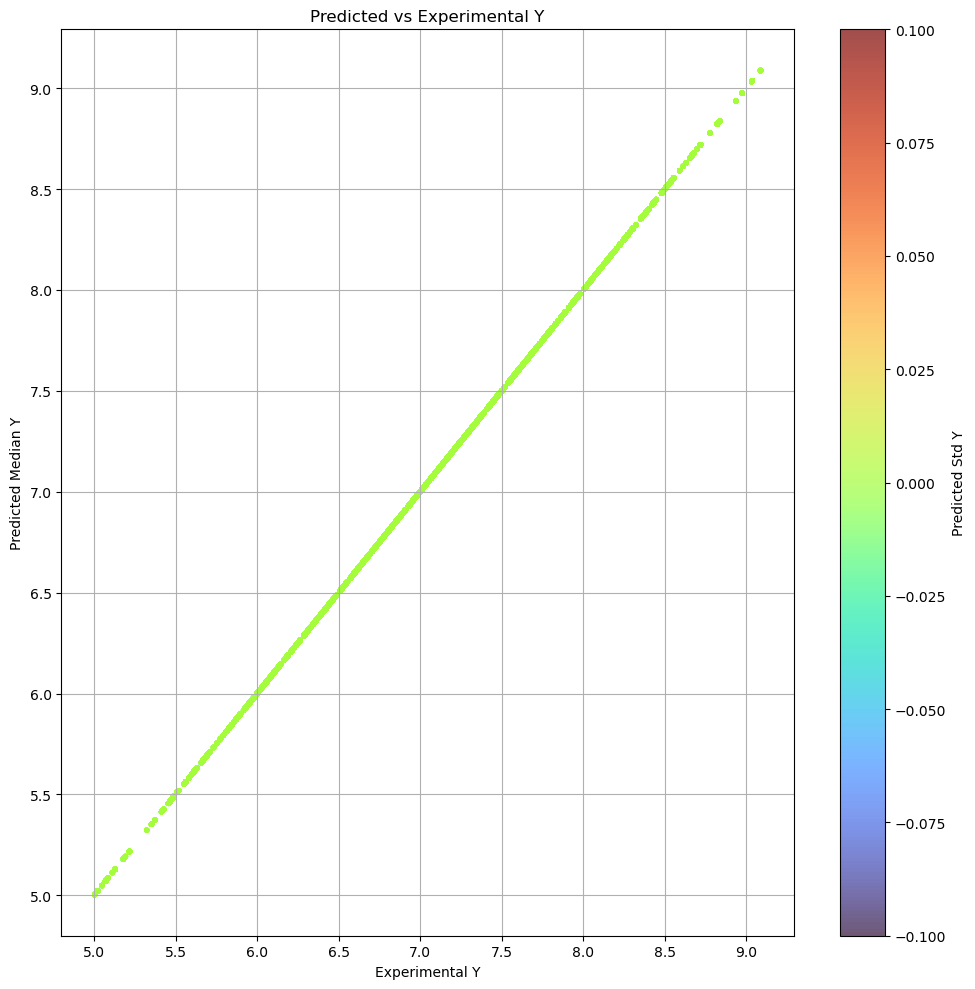

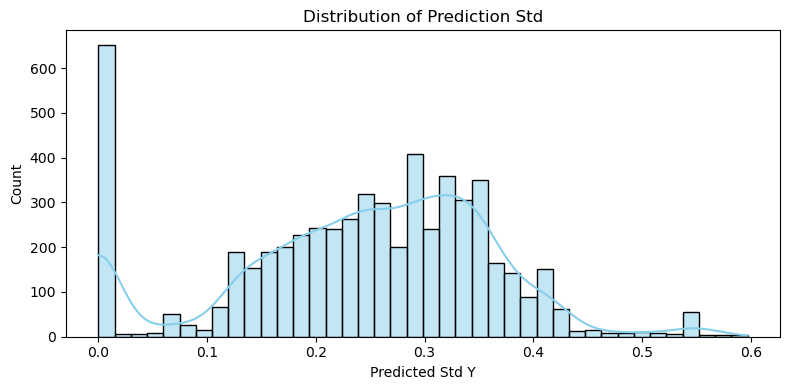

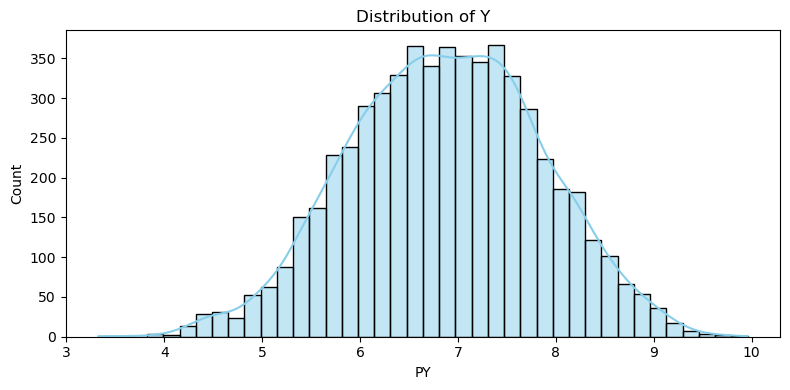

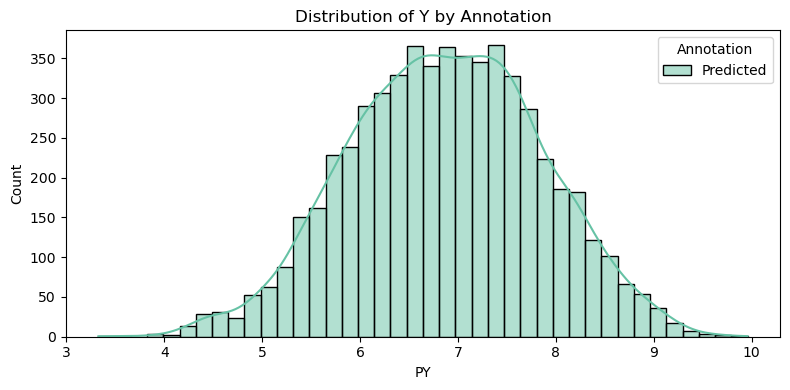

/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_84541/1447977027.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="muted")


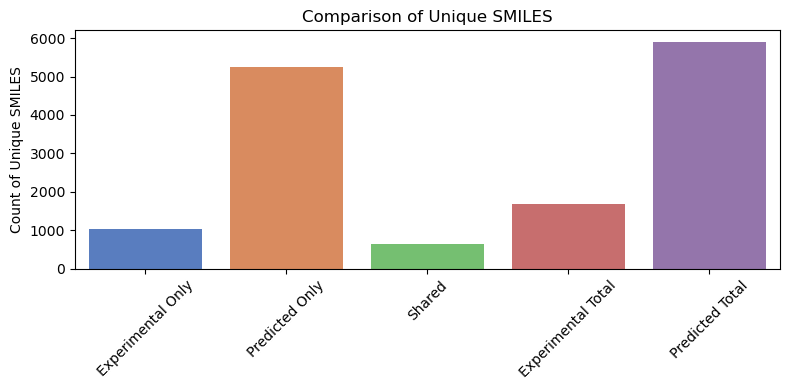

,SMILES,Y,Predicted_Std_Y,Annotation
0,CN(c1ccccc1OCC)c1[n]c(Nc2c[n]([n]c2C)C2CCNCC2)...,6.266803,NaN,Experimental
1,Cc1[n][n](cc1Nc1[n]c(Nc2ccccc2OCC)c(F)c[n]1)C1...,6.377786,NaN,Experimental
2,CN(c1ccccc1OCC)c1[n]c(Nc2c[n]([n]c2C)C2CCNCC2)...,5.627088,NaN,Experimental
3,Cc1[n][n](cc1Nc1[n]c(Nc2ccccc2OCC)c2cc[nH]c2[n...,6.093665,NaN,Experimental
4,Cc1[n][n](cc1Nc1[n]c(Oc2ccccc2OCC)c(Cl)c[n]1)C...,6.227678,NaN,Experimental
...,...,...,...,...
7447,c1n[nH]cc1C1CCCNC1,7.619937,0.020164,Predicted
7448,c1nn(C2CCOCC2)cc1Nc1ncc2sc(-c3cn[nH]c3)c(OC3CC...,7.119645,0.127794,Predicted
7449,c1nn(C2CCOCC2)cc1Nc1ncc2sc(-c3cn[nH]c3)c(OC3CC...,7.206423,0.196272,Predicted
7450,c1nn(C2CCOCC2)cc1Nc1ncc2sc(-c3cn[nH]c3)c(OC3CC...,7.161315,0.130983,Predicted


In [30]:
merged_df, output_df = prepare_and_plot_prediction_vs_experiment_complete_with_output(clean_df)
output_df

# Modeling validation

In [31]:
import time
from sklearn.metrics import mean_squared_error, r2_score
def full_rf_validation_pipeline_profiled():
    from rdkit import Chem
    from rdkit.Chem import DataStructs
    from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import KFold
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    from joblib import Parallel, delayed

    def compute_single_fp(smi, radius=2, n_bits=2048):
        from rdkit import Chem
        from rdkit.Chem import DataStructs
        from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            generator = GetMorganGenerator(radius=radius, fpSize=n_bits)
            fp = generator.GetFingerprint(mol)
            arr = np.zeros((1,), dtype=int)
            DataStructs.ConvertToNumpyArray(fp, arr)
            return arr
        return np.full(n_bits, 0)

    def compute_all_fingerprints_parallel(data, radius=3, n_bits=4096, n_jobs=-1):
        print("Starting fingerprint computation...")
        t0 = time.time()
        fps = Parallel(n_jobs=n_jobs)(
            delayed(compute_single_fp)(smi) for smi in tqdm(data["SMILES"])
        )
        print(f"Fingerprint computation completed in {time.time() - t0:.2f} seconds.")
        return np.array(fps)



    def evaluate_rf_on_augmentation(data, n_splits=3, n_repeats=3):
        print("Preparing dataset...")
        data = data.dropna(subset=["SMILES", "Y"]).reset_index(drop=True)
        all_fps = compute_all_fingerprints_parallel(data)
        results = []
        metrics = []

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold = 0
        exp_indices = data[data.Annotation == "Experimental"].index.to_numpy()

        print("Starting cross-validation...")
        for train_idx, test_idx in tqdm(kf.split(exp_indices), total=n_splits, desc="Cross-validation folds"):
            fold += 1
            print(f"\n[Fold {fold}] Preparing train/test split...")
            train_exp_idx = exp_indices[train_idx]
            test_exp_idx = exp_indices[test_idx]
            pred_idx = data[data.Annotation == "Predicted"].index.to_numpy()
            train_aug_idx = np.concatenate([train_exp_idx, pred_idx])

            X_train_exp = all_fps[train_exp_idx]
            y_train_exp = data.loc[train_exp_idx, "Y"].values
            X_train_aug = all_fps[train_aug_idx]
            y_train_aug = data.loc[train_aug_idx, "Y"].values
            X_test = all_fps[test_exp_idx]
            y_test = data.loc[test_exp_idx, "Y"].values
            smiles_test = data.loc[test_exp_idx, "SMILES"].values

            print(len(X_train_exp), len(y_train_exp), len(X_train_aug), len(y_train_aug), len(X_test), len(y_test))
            print("len(X_train_exp), len(y_train_exp), len(X_train_aug), len(y_train_aug), len(X_test), len(y_test)")

            preds_aug, preds_noaug = [], []

            for rep in tqdm(range(n_repeats), desc=f"Fold {fold} - training models", leave=False):
                print(f"  Training repeat {rep+1}/{n_repeats} [Augmented]")
                t1 = time.time()
                model_aug = RandomForestRegressor(n_jobs=-1, random_state=np.random.randint(10000), verbose=0, n_estimators=300)
                model_aug.fit(X_train_aug, y_train_aug)
                print(f"    Done in {time.time() - t1:.2f}s")

                print(f"  Training repeat {rep+1}/{n_repeats} [NoAug]")
                t2 = time.time()
                model_noaug = RandomForestRegressor(n_jobs=-1, random_state=np.random.randint(10000), verbose=0, n_estimators=300)
                model_noaug.fit(X_train_exp, y_train_exp)
                print(f"    Done in {time.time() - t2:.2f}s")

                preds_aug.append(model_aug.predict(X_test))
                preds_noaug.append(model_noaug.predict(X_test))

            print("  Evaluating predictions...")
            y_pred_aug = np.median(np.array(preds_aug), axis=0)
            y_pred_noaug = np.median(np.array(preds_noaug), axis=0)

            rmse_aug = mean_squared_error(y_test, y_pred_aug, squared=False)
            r2_aug = r2_score(y_test, y_pred_aug)
            rmse_noaug = mean_squared_error(y_test, y_pred_noaug, squared=False)
            r2_noaug = r2_score(y_test, y_pred_noaug)

            metrics.append({
                "Fold": fold,
                "RMSE_Aug": rmse_aug,
                "R2_Aug": r2_aug,
                "RMSE_NoAug": rmse_noaug,
                "R2_NoAug": r2_noaug
            })

            for i, smi in enumerate(smiles_test):
                true_y = y_test[i]
                aug_preds = [p[i] for p in preds_aug]
                noaug_preds = [p[i] for p in preds_noaug]

                results.append({
                    "SMILES": smi,
                    "True_Y": true_y,
                    "Median_Pred_Aug": np.median(aug_preds),
                    "Std_Pred_Aug": np.std(aug_preds),
                    "Med_AE_Aug": np.median(np.abs(np.array(aug_preds) - true_y)),
                    "Median_Pred_NoAug": np.median(noaug_preds),
                    "Std_Pred_NoAug": np.std(noaug_preds),
                    "Med_AE_NoAug": np.median(np.abs(np.array(noaug_preds) - true_y)),
                    "Fold": fold
                })

        print("\nCross-validation complete. Fold-wise RMSE and R²:")
        metrics_df = pd.DataFrame(metrics)
        print(metrics_df)

        return pd.DataFrame(results), metrics_df
    return evaluate_rf_on_augmentation

In [32]:
evaluate_fn = full_rf_validation_pipeline_profiled()
results_df, metrics_df = evaluate_fn(output_df)

Preparing dataset...
Starting fingerprint computation...


100%|██████████| 6801/6801 [00:01<00:00, 6393.60it/s]


Fingerprint computation completed in 1.18 seconds.
Starting cross-validation...


Cross-validation folds:   0%|          | 0/3 [00:00<?, ?it/s]


[Fold 1] Preparing train/test split...
1124 1124 6239 6239 562 562
len(X_train_exp), len(y_train_exp), len(X_train_aug), len(y_train_aug), len(X_test), len(y_test)


  Training repeat 1/3 [Augmented]
    Done in 8.21s
  Training repeat 1/3 [NoAug]


    Done in 0.95s
  Training repeat 2/3 [Augmented]
    Done in 8.42s
  Training repeat 2/3 [NoAug]


    Done in 0.97s
  Training repeat 3/3 [Augmented]
    Done in 8.25s
  Training repeat 3/3 [NoAug]


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Cross-validation folds:  33%|███▎      | 1/3 [00:27<00:55, 27.96s/it]

    Done in 0.93s
  Evaluating predictions...

[Fold 2] Preparing train/test split...
1124 1124 6239 6239 562 562
len(X_train_exp), len(y_train_exp), len(X_train_aug), len(y_train_aug), len(X_test), len(y_test)


  Training repeat 1/3 [Augmented]
    Done in 8.22s
  Training repeat 1/3 [NoAug]


    Done in 0.95s
  Training repeat 2/3 [Augmented]
    Done in 8.29s
  Training repeat 2/3 [NoAug]


    Done in 0.94s
  Training repeat 3/3 [Augmented]
    Done in 8.20s
  Training repeat 3/3 [NoAug]


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Cross-validation folds:  67%|██████▋   | 2/3 [00:55<00:27, 27.84s/it]

    Done in 0.95s
  Evaluating predictions...

[Fold 3] Preparing train/test split...
1124 1124 6239 6239 562 562
len(X_train_exp), len(y_train_exp), len(X_train_aug), len(y_train_aug), len(X_test), len(y_test)


  Training repeat 1/3 [Augmented]
    Done in 8.11s
  Training repeat 1/3 [NoAug]


    Done in 0.98s
  Training repeat 2/3 [Augmented]
    Done in 8.15s
  Training repeat 2/3 [NoAug]


    Done in 0.99s
  Training repeat 3/3 [Augmented]
    Done in 8.07s
  Training repeat 3/3 [NoAug]


/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pierre/miniconda3/envs/chemprop_v2/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Cross-validation folds: 100%|██████████| 3/3 [01:23<00:00, 27.73s/it]

    Done in 0.97s
  Evaluating predictions...

Cross-validation complete. Fold-wise RMSE and R²:
   Fold  RMSE_Aug    R2_Aug  RMSE_NoAug  R2_NoAug
0     1  0.445632  0.774673    0.527479  0.684302
1     2  0.459419  0.768820    0.538894  0.681916
2     3  0.411705  0.814153    0.509082  0.715843


# Analysis performances

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analyze_rf_validation_results(df_results):
    # === Scatter plot: True vs Predicted Median (Augmented), colored by Median Absolute Error ===
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(
        df_results["True_Y"],
        df_results["Median_Pred_Aug"],
        c=df_results["Med_AE_Aug"],
        cmap="turbo",
        s=20,
        alpha=0.7
    )
    plt.colorbar(scatter, label="Median Absolute Error (Aug)")
    plt.xlabel("True Y")
    plt.ylabel("Median Predicted Y (Augmented)")
    plt.title("True vs Predicted (Augmented RF)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Top 10 highest absolute errors ===
    top10 = df_results.sort_values("Med_AE_Aug", ascending=False).head(10)
    print("Top 10 compounds with highest Median Absolute Error (Augmented):")
    print(top10[["SMILES", "True_Y", "Median_Pred_Aug", "Med_AE_Aug"]])

    # === Barplot of RMSE and R² for each Fold ===
    fold_stats = df_results.groupby("Fold").apply(
        lambda g: pd.Series({
            "RMSE_Aug": np.sqrt(np.mean((g["True_Y"] - g["Median_Pred_Aug"]) ** 2)),
            "RMSE_NoAug": np.sqrt(np.mean((g["True_Y"] - g["Median_Pred_NoAug"]) ** 2)),
            "R2_Aug": np.corrcoef(g["True_Y"], g["Median_Pred_Aug"])[0, 1] ** 2,
            "R2_NoAug": np.corrcoef(g["True_Y"], g["Median_Pred_NoAug"])[0, 1] ** 2,
        })
    ).reset_index()

    # Melt for plotting
    rmse_melted = fold_stats.melt(id_vars="Fold", value_vars=["RMSE_Aug", "RMSE_NoAug"], var_name="Model", value_name="RMSE")
    r2_melted = fold_stats.melt(id_vars="Fold", value_vars=["R2_Aug", "R2_NoAug"], var_name="Model", value_name="R2")

    return fold_stats


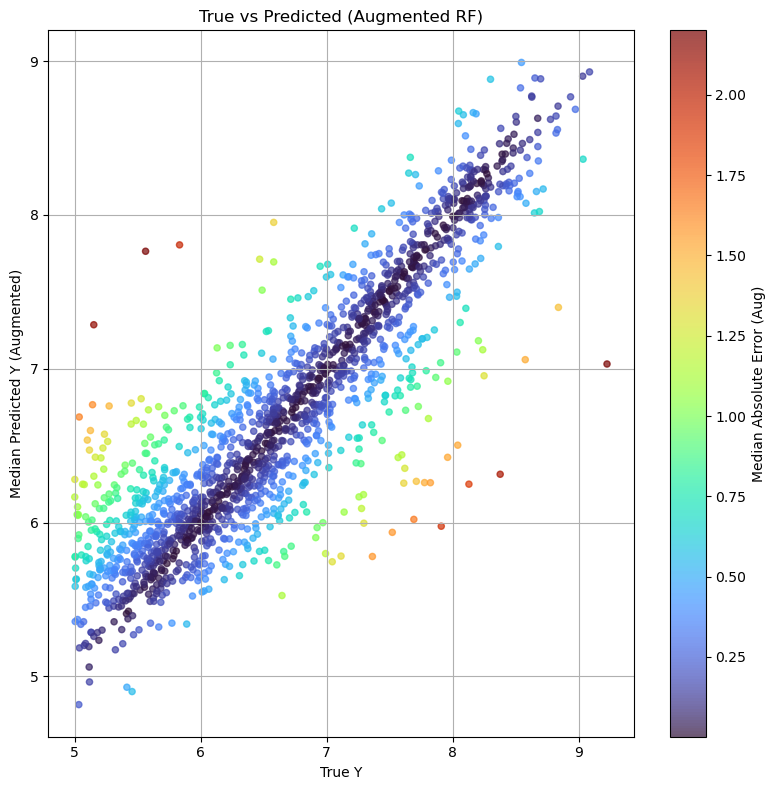

Top 10 compounds with highest Median Absolute Error (Augmented):
                                                 SMILES    True_Y  \
826   CC(C)(C)C(=O)N1CCC(CC1)[n]1cc(NC(=O)c2cccc([n]...  5.563043   
1116  C1CC(CCO1)N1CCC(CC1)c1cc(ccc1)Nc1[n]c2c(C3CC3)...  9.225848   
220   CP1CCC(CC1)[n]1cc(NC(=O)c2cccc([n]2)-c2cc[nH][...  5.151811   
341   CC1(C)C[n]2c(=O)cc([n]c2N1C(C)C)-c1c[nH]c2[n]c...  8.377786   
1066  CN(C)C(=O)c1[n][n](cc1NC(=O)c1cccc([n]1)-c1cc(...  5.832683   
297   C1CC(CCN1)c1cc(Nc2[n]c(-c3cc4ccccc4[s]3)c3cc[n...  7.910095   
637   C(NCCCOc1cc2[nH]c(cc2cc1)-c1[n][nH]c2cc[s]c21)...  8.129596   
881   NCC1CCN(CC1)c1ccc(Cl)cc1NC(=O)c1c[n][n]2cc(O)c...  7.692504   
1227  NCCC1CN(C1)c1[n]c(cc[n]1)-c1cc(ccc1O)-c1c[nH][...  5.036212   
428   CC(C)(C)C(=O)N1CCC(CC1)NC(=O)c1cc2[n]cc(Br)[n]...  5.142065   

      Median_Pred_Aug  Med_AE_Aug  
826          7.764024    2.200981  
1116         7.030941    2.194907  
220          7.286165    2.134354  
341          6.314011    2.0637

/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_84541/2287777831.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fold_stats = df_results.groupby("Fold").apply(


In [34]:
fold_stats = analyze_rf_validation_results(results_df)


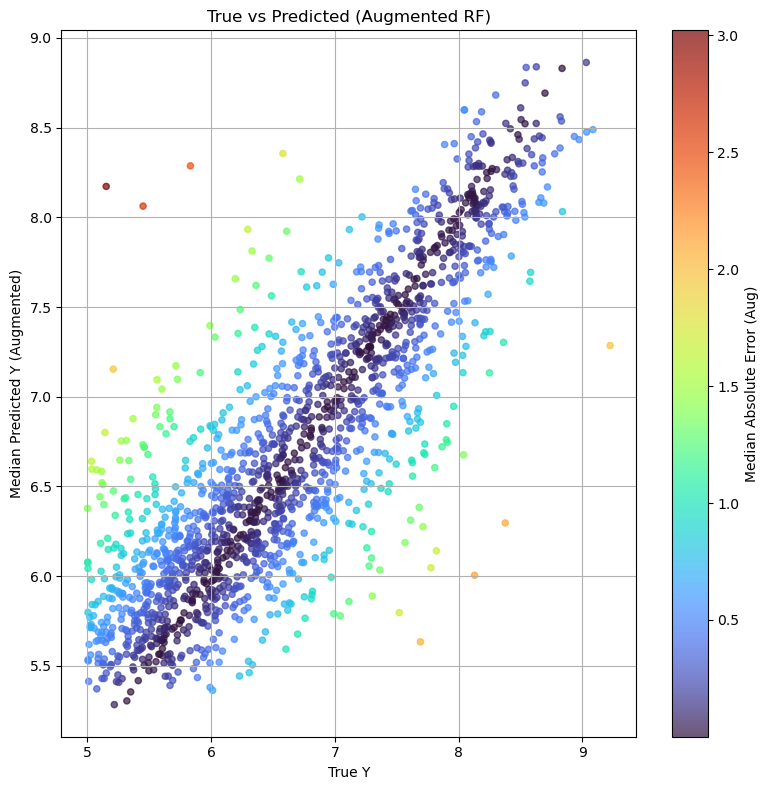

Top 10 compounds with highest Median Absolute Error (Augmented):
                                                 SMILES    True_Y  \
1310  CP1CCC(CC1)[n]1cc(NC(=O)c2cccc([n]2)-c2cc[nH][...  5.151811   
1338  CC(C)(C)C(=O)N1CCC(CC1)[n]1cc(NC(=O)c2cccc([n]...  5.449772   
1066  CN(C)C(=O)c1[n][n](cc1NC(=O)c1cccc([n]1)-c1cc(...  5.832683   
1181  C(NCCCOc1cc2[nH]c(cc2cc1)-c1[n][nH]c2cc[s]c21)...  8.129596   
341   CC1(C)C[n]2c(=O)cc([n]c2N1C(C)C)-c1c[nH]c2[n]c...  8.377786   
881   NCC1CCN(CC1)c1ccc(Cl)cc1NC(=O)c1c[n][n]2cc(O)c...  7.692504   
918   OC(=O)Cc1[n][n](cc1NC(=O)c1cccc([n]1)-c1cc[n][...  5.209012   
1116  C1CC(CCO1)N1CCC(CC1)c1cc(ccc1)Nc1[n]c2c(C3CC3)...  9.225848   
210   Cc1cc([nH][n]1)-c1cccc([n]1)C(=O)Nc1c[n]([n]c1...  6.580044   
866   C1CC(CCN1)[n]1cc(c[n]1)Nc1[n]c(-c2cc3ccccc3[s]...  7.777284   

      Median_Pred_Aug  Med_AE_Aug  
1310         8.172256    3.020446  
1338         8.062524    2.612752  
1066         8.286835    2.454152  
1181         6.004670    2.1249

/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_1183/2287777831.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fold_stats = df_results.groupby("Fold").apply(


In [204]:
fold_stats = analyze_rf_validation_results(results_df)


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cv_metrics(metrics_df):
    plt.figure(figsize=(12, 5))

    # Boxplot RMSE
    plt.subplot(1, 2, 1)
    rmse_melted = metrics_df.melt(id_vars="Fold", value_vars=["RMSE_Aug", "RMSE_NoAug"],
                                  var_name="Condition", value_name="RMSE")
    sns.boxplot(data=rmse_melted, x="Condition", y="RMSE", palette="Set2")
    plt.title("RMSE per Fold")
    plt.grid(True)

    # Boxplot R2
    plt.subplot(1, 2, 2)
    r2_melted = metrics_df.melt(id_vars="Fold", value_vars=["R2_Aug", "R2_NoAug"],
                                var_name="Condition", value_name="R²")
    sns.boxplot(data=r2_melted, x="Condition", y="R²", palette="Set2")
    plt.title("R² per Fold")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_84541/705906550.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rmse_melted, x="Condition", y="RMSE", palette="Set2")
/var/folders/2b/_90d0zxj2w3gcjdjskhc3xhw0000gn/T/ipykernel_84541/705906550.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=r2_melted, x="Condition", y="R²", palette="Set2")


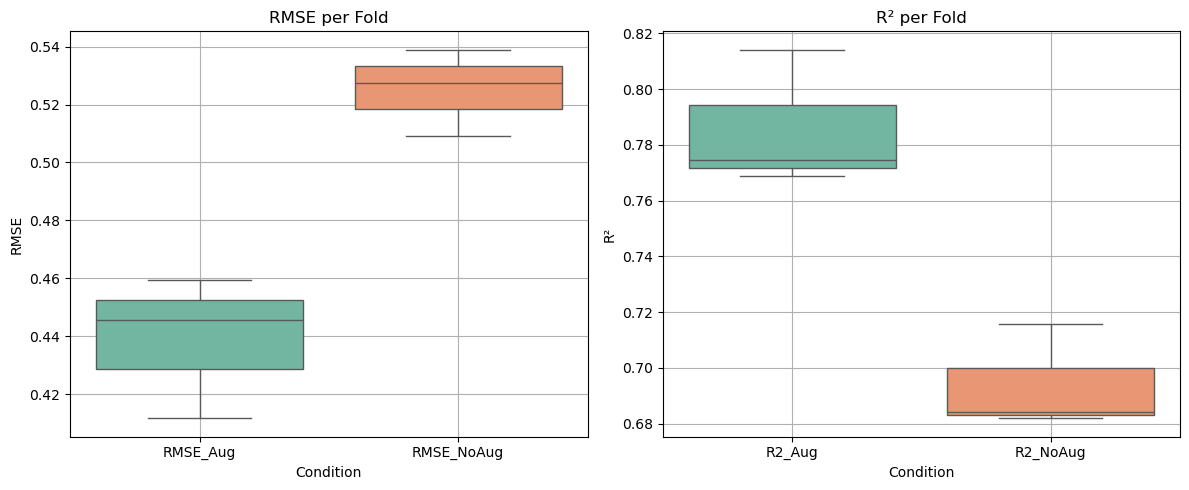

In [36]:
plot_cv_metrics(metrics_df)

In [207]:
metrics_df

,Fold,RMSE_Aug,R2_Aug,RMSE_NoAug,R2_NoAug
0,1,0.501088,0.720947,0.504356,0.717296
1,2,0.496348,0.721936,0.507219,0.709623
2,3,0.535080,0.685477,0.540299,0.679310


In [208]:
1

1